In [1]:
!pip -q install pydicom

     |████████████████████████████████| 2.0 MB 12.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/_Colab/UdacityHealth')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 

In [4]:
ds = pydicom.dcmread('test1.dcm')       
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.2.0'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patien

In [21]:
for it in ds:
  print(it.keyword,"-----", it.name)


SOPClassUID ----- SOP Class UID
SOPInstanceUID ----- SOP Instance UID
Modality ----- Modality
StudyDescription ----- Study Description
PatientID ----- Patient ID
PatientSex ----- Patient's Sex
PatientAge ----- Patient's Age
BodyPartExamined ----- Body Part Examined
PatientPosition ----- Patient Position
StudyInstanceUID ----- Study Instance UID
SeriesInstanceUID ----- Series Instance UID
SamplesPerPixel ----- Samples per Pixel
PhotometricInterpretation ----- Photometric Interpretation
Rows ----- Rows
Columns ----- Columns
BitsAllocated ----- Bits Allocated
BitsStored ----- Bits Stored
HighBit ----- High Bit
PixelRepresentation ----- Pixel Representation
PixelData ----- Pixel Data


In [27]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)       
    
    if ds.Modality != 'DX':
      print('Modality should be DX, however it is: ', ds.Modality)
      return None

    age = int(ds.PatientAge)
    if age < 1 & age > 95:
      print('Model was trained with Patients between 1 and 95 years old. It will still proceed.')
    
    if ds.BodyPartExamined.upper() != 'CHEST':
      print('Model tested in Chest X-rays, instead got an X-Ray for: ', ds.BodyPartExamined)
      return None

    if ds.PatientPosition.upper() not in ['AP', 'PA']:
      print('Model tested in AP or PA View Position, instead got view-position: ', ds.PatientPosition)
      return None

    img = ds.pixel_array
    
    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    from skimage.transform import resize

    #img_ = (img - img_mean) 
    #img_ /= img_std
    img_ = img/ 255.0
    proc_img = resize(img_, img_size)
    
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path, init_lr=1e-4):
    from tensorflow.keras.models import model_from_json
    from tensorflow.keras.optimizers import Adam

    model = model_from_json(open(model_path).read())
    model.load_weights(weight_path)
    
    optimizer = Adam(learning_rate=init_lr)
    loss = 'binary_crossentropy'
    metrics = ['AUC',
              'binary_accuracy',
              keras.metrics.SensitivityAtSpecificity(0.5, name='sensitivity'),
              keras.metrics.FalseNegatives(name="fn"),
              keras.metrics.FalsePositives(name="fp"),
              keras.metrics.TrueNegatives(name="tn"),
              keras.metrics.TruePositives(name="tp"),
              keras.metrics.Precision(name="precision"),
              keras.metrics.Recall(name="recall"),
            ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    pred = model.predict(img)
    
    if pred > thresh:
        previsao = 'Detected pneumonia.'
    else:
        previsao = "Hasn't detected Pneumonia."

    return previsao 

Load file test1.dcm ...
Load file test2.dcm ...
Load file test3.dcm ...
Load file test4.dcm ...
Model tested in Chest X-rays, instead got an X-Ray for:  RIBCAGE
Load file test5.dcm ...
Modality should be DX, however it is:  CT
Load file test6.dcm ...
Model tested in AP or PA View Position, instead got view-position:  XX


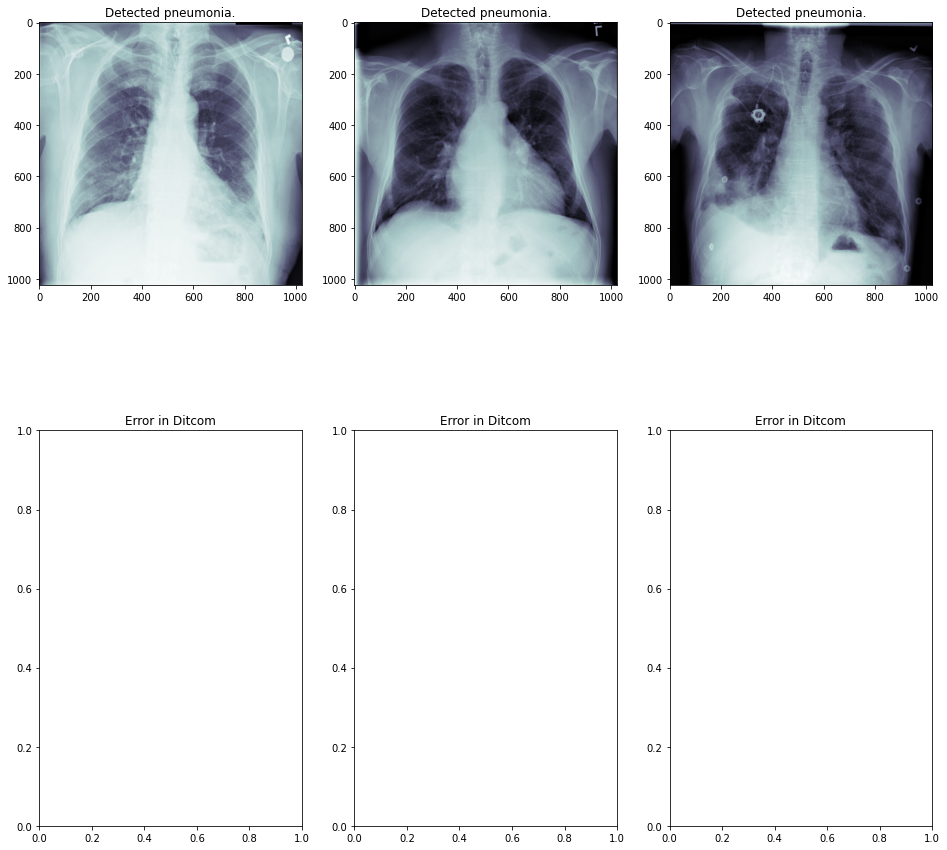

In [29]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = "my_best_model.json"
weight_path = "vgg16_val_loss_3_layers__my_model.best.hdf5"

IMG_SIZE = (1, 224, 224, 3) # This might be different if you did not use vgg16
my_model = load_model(model_path, weight_path)
thresh = 0.41

# use the .dcm files to test your prediction
rows = 2
cols = 3

fig, m_axs = plt.subplots(rows, cols, figsize = (16, 16))

for i, c_ax in zip(test_dicoms,  m_axs.flatten()):
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        c_ax.set_title("Error in Ditcom")
        continue
    
    img_mean = np.mean(img)    
    img_std  = np.std(img)
    
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    c_ax.imshow(img, cmap = 'bone')
    c_ax.set_title(pred)
    